# GOOGL stock 'Close' value prediction

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

## Stock data function configured to drop all columns except 'Open','High' and 'Close'

In [8]:
def get_stock_data(stock_name, normalized=0):
    url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name

    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stock = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stock)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) 
    return df

## Loading GOOGL stock data from yahoo.com

In [10]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.head()

,Open,High,Close
0,847.349976,848.830017,844.929993
1,844.950012,850.669983,849.669983
2,847.650024,848.359985,847.809998
3,851.080017,852.619995,851.000000
4,848.000000,853.789978,851.359985


## Saving the data to a file for a future use

In [12]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [14]:
df['High'] = df['High'] / 100
df['Open'] = df['Open'] / 100
df['Close'] = df['Close'] / 100
df.head(5)

,Open,High,Close
0,8.4735,8.4883,8.4493
1,8.4495,8.5067,8.4967
2,8.4765,8.4836,8.4781
3,8.5108,8.5262,8.5100
4,8.4800,8.5379,8.5136


## Updated load_data function from lstm.py, configured to accept any amount of features. It is set to calculate the last feature as a result.

In [15]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [19]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [17]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1156, 22, 3)
y_train (1156,)
X_test (129, 22, 3)
y_test (129,)


## Loading the model sequence structure

In [21]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

## Executing the model & RMS/RMSE results

In [22]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=1)

Train on 1040 samples, validate on 116 samples
Epoch 1/500
1040/1040 [==============================] - 3s - loss: 54.4479 - acc: 0.0000e+00 - val_loss: 55.3397 - val_acc: 0.0000e+00
Epoch 2/500
1040/1040 [==============================] - 1s - loss: 53.9240 - acc: 0.0000e+00 - val_loss: 54.7664 - val_acc: 0.0000e+00
Epoch 3/500
1040/1040 [==============================] - 1s - loss: 53.3421 - acc: 0.0000e+00 - val_loss: 54.0150 - val_acc: 0.0000e+00
Epoch 4/500
1040/1040 [==============================] - 1s - loss: 52.5936 - acc: 0.0000e+00 - val_loss: 53.0274 - val_acc: 0.0000e+00
Epoch 5/500
1040/1040 [==============================] - 1s - loss: 51.5985 - acc: 0.0000e+00 - val_loss: 51.7602 - val_acc: 0.0000e+00
Epoch 6/500
1040/1040 [==============================] - 1s - loss: 50.3432 - acc: 0.0000e+00 - val_loss: 50.2000 - val_acc: 0.0000e+00
Epoch 7/500
1040/1040 [==============================] - 1s - loss: 48.8046 - acc: 0.0000e+00 - val_loss: 48.3070 - val_acc: 0.0000e+00
E

In [23]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.08 MSE (0.29 RMSE)
Test Score: 0.04 MSE (0.20 RMSE)


In [24]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

## Predictions vs Real results

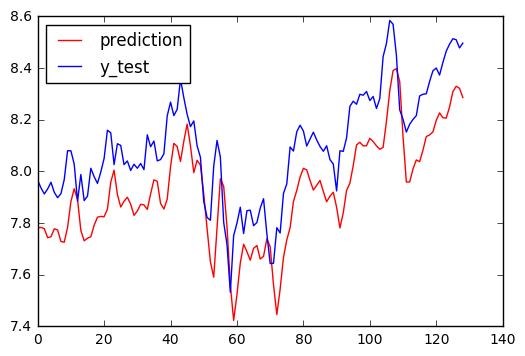

In [25]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()